LRGB\pascalvoc-sp
graph0:
460 nodes
14 features
value 0-490.5
mean 31.49, std dev 91.25
2657 unique values

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import LRGBDataset
from torch_geometric.nn import GCNConv

Choose dataset to be used

In [2]:
dataset = LRGBDataset(root='..\data\LRGB', name='PascalVOC-SP')
data = dataset[0]

Make train, validate, test masks

In [ ]:
def make_masks(num_nodes, train_ratio=0.7, val_ratio=0.15, seed=42):
    torch.manual_seed(seed) #same seed for every run of ipynb
    perm = torch.randperm(num_nodes)
    n_train = int(train_ratio * num_nodes)
    n_val = int(val_ratio * num_nodes)

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[perm[:n_train]] = True
    val_mask[perm[n_train:n_train+n_val]] = True
    test_mask[perm[n_train+n_val:]] = True

    return train_mask, val_mask, test_mask


Basic GCN model

In [78]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        #x  = F.dropout(x, p=0.5, training=self.training)    #in the official example
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [141]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    if isinstance(out, tuple):  # because quantized model returns out and comm params
        out = out[0]
    
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)

    if isinstance(out, tuple):  # because quantized model returns out and comm params
        out = out[0]

    pred = out.argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs  # [train_acc, val_acc, test_acc]


Grid search

In [84]:
import itertools

data.train_mask, data.val_mask, data.test_mask = make_masks(data.num_nodes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

hidden_sizes = [64, 128, 256]
lrs = [0.01, 0.05]
dropouts = [0.3, 0.5]
epochs = [500, 750, 1000] 

weight_decay = 5e-4
results = []

for hidden, lr, drop, epoch in itertools.product(hidden_sizes, lrs, dropouts, epochs):
    model = GCN(data.num_features, hidden, int(data.y.max().item()+1), drop).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0
    best_test = 0

    for e in range(epoch):
        train(model, optimizer, data)
        train_acc, val_acc, test_acc = test(model, data)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test = test_acc

    results.append((hidden, lr, drop, epoch, best_val_acc, best_test))
    print(f"h={hidden}, lr={lr}, drop={drop}, ep={epoch} "
          f"| best val={best_val_acc:.4f}, test={best_test:.4f}")

h=64, lr=0.01, drop=0.3, ep=500 | best val=0.9783, test=0.9022
h=64, lr=0.01, drop=0.3, ep=750 | best val=0.9783, test=0.8804
h=64, lr=0.01, drop=0.3, ep=1000 | best val=0.9783, test=0.9239
h=64, lr=0.01, drop=0.5, ep=500 | best val=0.9674, test=0.9022
h=64, lr=0.01, drop=0.5, ep=750 | best val=0.9783, test=0.8913
h=64, lr=0.01, drop=0.5, ep=1000 | best val=0.9783, test=0.8913
h=64, lr=0.05, drop=0.3, ep=500 | best val=0.9565, test=0.8696
h=64, lr=0.05, drop=0.3, ep=750 | best val=0.9783, test=0.9022
h=64, lr=0.05, drop=0.3, ep=1000 | best val=0.9783, test=0.8913
h=64, lr=0.05, drop=0.5, ep=500 | best val=0.9565, test=0.9239
h=64, lr=0.05, drop=0.5, ep=750 | best val=0.9565, test=0.9022
h=64, lr=0.05, drop=0.5, ep=1000 | best val=0.9565, test=0.8804
h=128, lr=0.01, drop=0.3, ep=500 | best val=0.9783, test=0.9130
h=128, lr=0.01, drop=0.3, ep=750 | best val=0.9891, test=0.9457
h=128, lr=0.01, drop=0.3, ep=1000 | best val=0.9783, test=0.8478
h=128, lr=0.01, drop=0.5, ep=500 | best val=0.9

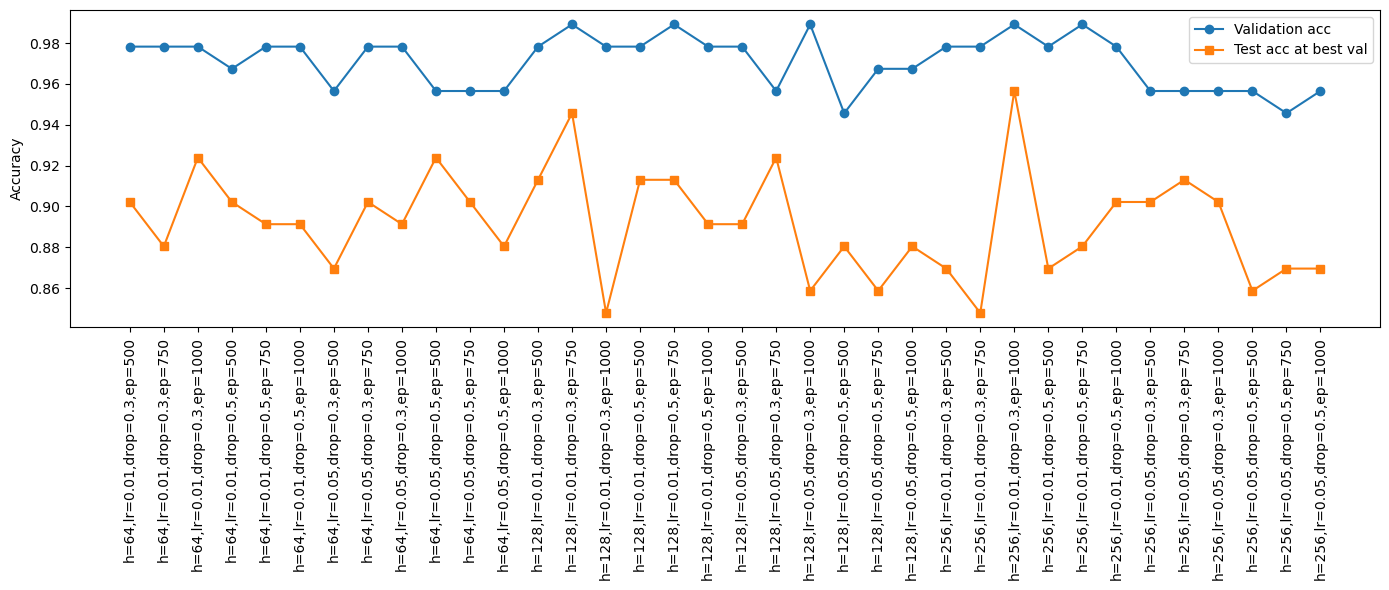

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results, columns=["hidden","lr","dropout","epochs","val_acc","test_acc"])

labels = [f"h={h},lr={lr},drop={d},ep={ep}" for h, lr, d, ep, _, _ in results]
val_accs = [val for _, _, _, _, val, _ in results]
test_accs = [test for _, _, _, _, _, test in results]

plt.figure(figsize=(14,6))
plt.plot(val_accs, 'o-', label="Validation acc")
plt.plot(test_accs, 's-', label="Test acc at best val")
plt.xticks(range(len(labels)), labels, rotation=90)
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

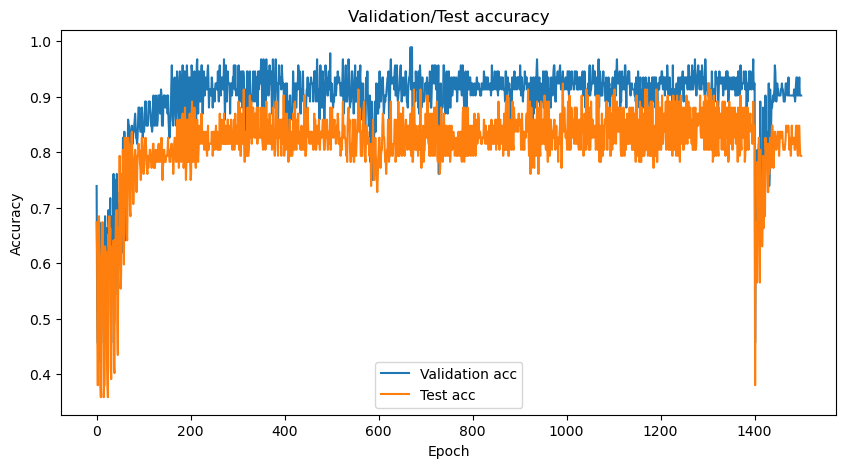

In [89]:
# check if 750 epochs is enough

model = GCN(data.num_features, 128, int(data.y.max().item()+1), 0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

val_accs, test_accs = [], []

for epoch in range(1500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = torch.nn.functional.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    tr_acc, va_acc, te_acc = test(model, data)
    val_accs.append(va_acc)
    test_accs.append(te_acc)

plt.figure(figsize=(10,5))
plt.plot(val_accs, label="Validation acc")
plt.plot(test_accs, label="Test acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Validation/Test accuracy")
plt.legend()
plt.show()


Chosen model: h=128, lr=0.01, drop=0.3, ep=750

In [ ]:
# globally used variables and methods

hidden = 128
output = int(data.y.max().item()+1)
lr = 0.01
drop = 0.3
epochs = 750

#feature_dtype = data.x.dtype    # torch.float32
feature_size = data.x.element_size() # size of one element in tensor (feature) in bytes

def acc_results(results):
    val_accs = [r[0] for r in results]
    test_accs = [r[1] for r in results]

    val_accs = torch.tensor(val_accs, dtype=torch.float32)
    test_accs = torch.tensor(test_accs, dtype=torch.float32)

    mean_val, std_val = val_accs.mean().item(), val_accs.std().item()
    mean_test, std_test = test_accs.mean().item(), test_accs.std().item()

    print('Accuracy results per seed:')
    for v, t in results:
        print(f"Validation = {v:.4f}, test = {t:.4f}")

    print(f"Validation mean ± std: {mean_val:.4f} ± {std_val:.4f}")
    print(f"Test mean ± std: {mean_test:.4f} ± {std_test:.4f}")

    return

def neigh_size(data, k=None):   # calculate size of neighborhood for each node, limit k when sampling
    
    neigh_count = torch.zeros(data.num_nodes, dtype=torch.int64)
    for target in data.edge_index[1]:
        neigh_count[target] += 1

    if k is not None:
        neigh_count[neigh_count > k] = k

    return neigh_count

def layer_comm(data, feature_dim, quant=None, k=None):    # calculate total communication in one layer; feature_dim = number of features
    total_size = 0
    
    if quant is not None:
        msg_size = feature_dim * quant.feat_size    # use quantized size of feature
        total_size = quant.params_size  # add scale and min size
    else:
        msg_size = feature_dim * feature_size   # size of one message one node sends in bytes

    
    total_msg = neigh_size(data, k).sum().item()    # number of messages in one layer
    total_size += msg_size * total_msg

    return total_size


Running seeds

In [139]:
seeds = [42, 73, 123, 320, 501]

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)   # have to explicitly disable it (tried to enable deterministic but it was trowing an error)

def run_seeds(ModelClass, data=data, QuantizerClass=None):
    results = []
    quantizer = None

    for seed in seeds:
        set_seed(seed)

        if QuantizerClass is not None:
            quantizer = QuantizerClass()
            model = ModelClass(data.num_features, hidden, output, drop, quantizer=quantizer).to(device)
        else:
            model = ModelClass(data.num_features, hidden, output, drop).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_acc = 0
        best_test = 0

        for epoch in range(epochs):
            data.to(device)
            train(model, optimizer, data)
            train_acc, val_acc, test_acc = test(model, data)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_test = test_acc

        results.append((best_val_acc, best_test))

    if QuantizerClass is not None:
        return results, quantizer   # for access in comm calculation, one representative quantizer
    return results

Results of basic GCN model

In [95]:
gcn_results = run_seeds(GCN)
acc_results(gcn_results)

gcn_total = layer_comm(data, data.x.shape[1])   # input feature size
print(f"Total communication in layer 1: { gcn_total / 1024:.2f} KB")


Accuracy results per seed:
Validation = 0.9891, test = 0.9565
Validation = 0.9783, test = 0.9239
Validation = 0.9783, test = 0.9022
Validation = 0.9891, test = 0.9239
Validation = 0.9891, test = 0.9239
Validation mean ± std: 0.9848 ± 0.0060
Test mean ± std: 0.9261 ± 0.0194
Total communication in layer 1: 143.94 KB


Quantized GCN models

In [125]:
from abc import ABC, abstractmethod

class Quantizer(ABC):
    def __init__(self):
        self.feat_size = 1   # compress each feature to 1 byte, 8 bits 
        self.min = 0    # min and max possible numbers to code with 8 bits
        self.max = 255

    @abstractmethod
    def _find_minmax(self, x):
        pass

    def quantize(self, x):
        x_min, x_max = self._find_minmax(x)
        scale = (x_max - x_min) / (self.max - self.min) # edge case when max=min ?  + 1e-8
        x_quant = torch.clamp(((x - x_min) / scale).round(), self.min, self.max)
        x_quant = x_quant.to(torch.uint8)   # compress to int
        # calculate size of scale and min which are sent once
        self.params_size = scale.numel() * scale.element_size() + x_min.numel() * x_min.element_size()

        return x_quant, (scale, x_min)  # all of this is part of communication
    
    def dequantize(self, x_quant, params):
        scale, x_min = params
        return x_quant.float() * scale + x_min


In [126]:
class GlobalQuantizer(Quantizer):
    def _find_minmax(self, x):
        x_min = x.min()
        x_max = x.max()
        return x_min, x_max

In [127]:
class FeatureQuantizer(Quantizer):
    def _find_minmax(self, x):
        x_min = x.min(dim=0, keepdim=True).values
        x_max = x.max(dim=0, keepdim=True).values
        return x_min, x_max

In [128]:
class NodeQuantizer(Quantizer):
    def _find_minmax(self, x):
        x_min = x.min(dim=1, keepdim=True).values
        x_max = x.max(dim=1, keepdim=True).values
        return x_min, x_max

In [129]:
class GCNQuantized(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, quantizer=GlobalQuantizer):
        super().__init__()
        self.quantizer = quantizer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x_quant, params = self.quantizer.quantize(x)
        x = self.quantizer.dequantize(x_quant, params)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x, (x_quant, params)

In [142]:
q1_results, q1 = run_seeds(GCNQuantized, data, QuantizerClass=GlobalQuantizer)
acc_results(q1_results)

q1_total = layer_comm(data, data.x.shape[1], quant=q1)   # input feature size and quantizer to retrieve sizes
q1_diff = gcn_total - q1_total

print(f"Total communication in layer 1 using global quantization: { q1_total / 1024:.2f} KB")
print(f"Communication lowered by { q1_diff / 1024:.2f} KB compared to the basic model")

Accuracy results per seed:
Validation = 0.9783, test = 0.9130
Validation = 0.9783, test = 0.9130
Validation = 0.9891, test = 0.9348
Validation = 0.9783, test = 0.9022
Validation = 0.9674, test = 0.8913
Validation mean ± std: 0.9783 ± 0.0077
Test mean ± std: 0.9109 ± 0.0161
Total communication in layer 1 using global quantization: 35.99 KB
Communication lowered by 107.95 KB compared to the basic model


In [144]:
q2_results, q2 = run_seeds(GCNQuantized, data, QuantizerClass=FeatureQuantizer)
acc_results(q2_results)

q2_total = layer_comm(data, data.x.shape[1], quant=q2)   # input feature size and quantizer to retrieve sizes
q2_diff = gcn_total - q2_total

print(f"Total communication in layer 1 using global quantization: { q2_total / 1024:.2f} KB")
print(f"Communication lowered by { q2_diff / 1024:.2f} KB compared to the basic model")

Accuracy results per seed:
Validation = 0.9891, test = 0.9457
Validation = 0.9783, test = 0.9348
Validation = 0.9891, test = 0.8587
Validation = 0.9891, test = 0.9348
Validation = 0.9891, test = 0.9565
Validation mean ± std: 0.9870 ± 0.0049
Test mean ± std: 0.9261 ± 0.0387
Total communication in layer 1 using global quantization: 36.09 KB
Communication lowered by 107.84 KB compared to the basic model


In [145]:
q3_results, q3 = run_seeds(GCNQuantized,data, QuantizerClass=NodeQuantizer)
acc_results(q3_results)

q3_total = layer_comm(data, data.x.shape[1], quant=q3)   # input feature size and quantizer to retrieve sizes
q3_diff = gcn_total - q3_total

print(f"Total communication in layer 1 using global quantization: { q3_total / 1024:.2f} KB")
print(f"Communication lowered by { q3_diff / 1024:.2f} KB compared to the basic model")

Accuracy results per seed:
Validation = 0.9783, test = 0.9348
Validation = 0.9783, test = 0.9348
Validation = 0.9783, test = 0.9130
Validation = 0.9783, test = 0.9130
Validation = 0.9783, test = 0.9348
Validation mean ± std: 0.9783 ± 0.0000
Test mean ± std: 0.9261 ± 0.0119
Total communication in layer 1 using global quantization: 39.58 KB
Communication lowered by 104.36 KB compared to the basic model


Basic GCN model using neighbor sparsification

In [149]:
# insight to the basic model

full_neigh = neigh_size(data)

print("Min messages per node:", full_neigh.min().item())
print("Max messages per node:", full_neigh.max().item())

gcn_l2 = layer_comm(data, feature_dim=hidden)
full_gcn = gcn_total + gcn_l2

print(f"Total communication of basic model through both layers: { full_gcn / 1024:.2f} KB")

Min messages per node: 2
Max messages per node: 10
Total communication of basic model through both layers: 1459.94 KB


In [147]:
from torch_geometric.loader import NeighborLoader

sampling = [[5,5], [5,3], [3,3]]

sample1 = sampling[0]
# full batch as previously
nl1 = NeighborLoader(data, num_neighbors=sample1, batch_size=data.num_nodes, shuffle=False)
batch1 = next(iter(nl1))

nl1_results = run_seeds(GCN, data=batch1)
acc_results(nl1_results)

nl1_l1 = layer_comm(data, data.x.shape[1], quant=None, k=sample1[0])
nl1_l2 = layer_comm(data, hidden, quant=None, k=sample1[1])
nl1_total = nl1_l1 + nl1_l2

nl1_diff = full_gcn - nl1_total

print(f"Total communication with sampling sizes {sample1}: { nl1_total / 1024:.2f} KB")
print(f"Communication lowered by { nl1_diff / 1024:.2f} KB compared to the basic model")

Accuracy results per seed:
Validation = 0.9674, test = 0.9022
Validation = 0.9783, test = 0.9130
Validation = 0.9783, test = 0.8913
Validation = 0.9783, test = 0.9130
Validation = 0.9783, test = 0.9348
Validation mean ± std: 0.9761 ± 0.0049
Test mean ± std: 0.9109 ± 0.0161
Total communication with sampling sizes [5, 5]: 1226.41 KB
Communication lowered by 233.52 KB compared to the basic model


In [150]:
sample2 = sampling[1]
# full batch as previously
nl2 = NeighborLoader(data, num_neighbors=sample2, batch_size=data.num_nodes, shuffle=False)
batch2 = next(iter(nl2))

nl2_results = run_seeds(GCN, data=batch2)
acc_results(nl2_results)

nl2_l1 = layer_comm(data, data.x.shape[1], quant=None, k=sample2[0])
nl2_l2 = layer_comm(data, hidden, quant=None, k=sample2[1])
nl2_total = nl2_l1 + nl2_l2

nl2_diff = full_gcn - nl2_total

print(f"Total communication with sampling sizes {sample2}: { nl2_total / 1024:.2f} KB")
print(f"Communication lowered by { nl2_diff / 1024:.2f} KB compared to the basic model")

Accuracy results per seed:
Validation = 0.9674, test = 0.9022
Validation = 0.9674, test = 0.9130
Validation = 0.9783, test = 0.8913
Validation = 0.9783, test = 0.9130
Validation = 0.9783, test = 0.9348
Validation mean ± std: 0.9739 ± 0.0060
Test mean ± std: 0.9109 ± 0.0161
Total communication with sampling sizes [5, 3]: 809.91 KB
Communication lowered by 650.02 KB compared to the basic model


In [151]:
sample3 = sampling[2]
# full batch as previously
nl3 = NeighborLoader(data, num_neighbors=sample3, batch_size=data.num_nodes, shuffle=False)
batch3 = next(iter(nl3))

nl3_results = run_seeds(GCN, data=batch3)
acc_results(nl3_results)

nl3_l1 = layer_comm(data, data.x.shape[1], quant=None, k=sample3[0])
nl3_l2 = layer_comm(data, hidden, quant=None, k=sample3[1])
nl3_total = nl3_l1 + nl3_l2

nl3_diff = full_gcn - nl3_total

print(f"Total communication with sampling sizes {sample3}: { nl3_total / 1024:.2f} KB")
print(f"Communication lowered by { nl3_diff / 1024:.2f} KB compared to the basic model")

Accuracy results per seed:
Validation = 0.9565, test = 0.9239
Validation = 0.9674, test = 0.9239
Validation = 0.9565, test = 0.8696
Validation = 0.9674, test = 0.9022
Validation = 0.9565, test = 0.9348
Validation mean ± std: 0.9609 ± 0.0060
Test mean ± std: 0.9109 ± 0.0260
Total communication with sampling sizes [3, 3]: 764.36 KB
Communication lowered by 695.58 KB compared to the basic model


In [174]:
from torch_geometric.utils import degree

def topk_edges(data, k):
    source, target = data.edge_index
    deg = degree(source, data.num_nodes)   # deg[i] = number of outgoing edges of node i 

    new_edges = []
    for node in range(data.num_nodes):
        neighbors = target[source == node]
        if len(neighbors) > k:
            neighbors = neighbors[deg[neighbors].argsort(descending=True)[:k]]  # take only top k neighs with highest degrees
        for neigh in neighbors:
            new_edges.append([node, neigh])

    new_edges = torch.tensor(new_edges, dtype=torch.int64).t().contiguous()
    data_topk = data.clone()
    data_topk.edge_index = new_edges
    
    return data_topk

In [176]:
data_topk = topk_edges(data, k=3)
topk_results = run_seeds(GCN, data_topk)
acc_results(topk_results)


topk_l1 = layer_comm(data_topk, data.x.shape[1])
topk_l2 = layer_comm(data_topk, hidden)
topk_total = topk_l1 + topk_l2

topk_diff = full_gcn - topk_total

print(f"Total communication with sampling top 3 highest degree neighbors: { topk_total / 1024:.2f} KB")
print(f"Communication lowered by { topk_diff / 1024:.2f} KB compared to the basic model")

Accuracy results per seed:
Validation = 0.9565, test = 0.8804
Validation = 0.9565, test = 0.9022
Validation = 0.9565, test = 0.8913
Validation = 0.9565, test = 0.8913
Validation = 0.9565, test = 0.8804
Validation mean ± std: 0.9565 ± 0.0000
Test mean ± std: 0.8891 ± 0.0091
Total communication with sampling top 3 highest degree neighbors: 764.36 KB
Communication lowered by 695.58 KB compared to the basic model
